# MultiVelo Fig5

Data for this figure can be found at the links below:

RNA: https://figshare.com/account/projects/164299/articles/22575358

ATAC: https://figshare.com/account/projects/164299/articles/22575343

If you do not download them manually, the notebook will do so automatically.

In [1]:
import os
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import sys
import multivelo as mv
import matplotlib.pyplot as plt
import requests
sys.path.append('../')
print(sys.path)

['/Users/jake/Desktop/MultiVelo/multivelo_demo/fig5', '/Users/jake/opt/anaconda3/lib/python39.zip', '/Users/jake/opt/anaconda3/lib/python3.9', '/Users/jake/opt/anaconda3/lib/python3.9/lib-dynload', '', '/Users/jake/.local/lib/python3.9/site-packages', '/Users/jake/opt/anaconda3/lib/python3.9/site-packages', '/Users/jake/opt/anaconda3/lib/python3.9/site-packages/aeosa', '/Users/jake/MWNN', '/Users/jake/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions', '/Users/jake/.ipython', '../']


In [2]:
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
np.set_printoptions(suppress=True)

In [3]:
rna_url = "https://figshare.com/ndownloader/files/40064320"
atac_url = "https://figshare.com/ndownloader/files/40064311"

rna_path = "3423_MV_2_adata_postpro.h5ad"
atac_path = "3423_MV_2_adata_atac_postpro.h5ad" 

In [4]:
adata_rna = sc.read(rna_path, backup_url=rna_url)
adata_atac = sc.read(atac_path, backup_url=atac_url)

  0%|          | 0.00/202M [00:00<?, ?B/s]

  0%|          | 0.00/122M [00:00<?, ?B/s]

## Running multi-omic dynamical model

MultiVelo incorporates chromatin accessibility information into RNA velocity and achieves better lineage predictions.

The detailed argument list can be shown with "help(mv.recover_dynamics_chrom)".

### WARNING:

The recover_dynamics_chrom() step can take a long time, even with parallelization. As such, we added a h5ad file to figshare containing the AnnData object returned by recover_dynamics_chrom(). In absence of a local h5ad file of the same name, a cell below the recover_dynamics_chrom() step will download it automatically using sc.read(). If you want to run this notebook in shorter amount of time, then you can run that cell first and skip the preprocessing done in the cells above it. However, if you want to run all cells, including the preprocessing steps, the notebook will write and save the h5ad file itself rather than downloading it from figshare.

recovering dynamics (using 1/10 cores)


  0%|          | 0/599 [00:00<?, ?gene/s]

    finished (0:11:03) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/11605 [00:00<?, ?cells/s]

    finished (0:00:20) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 7 regions of root cells and 1 region of end points .
    finished (0:00:02) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:02) --> added 
    'latent_time', shared time (adata.obs)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


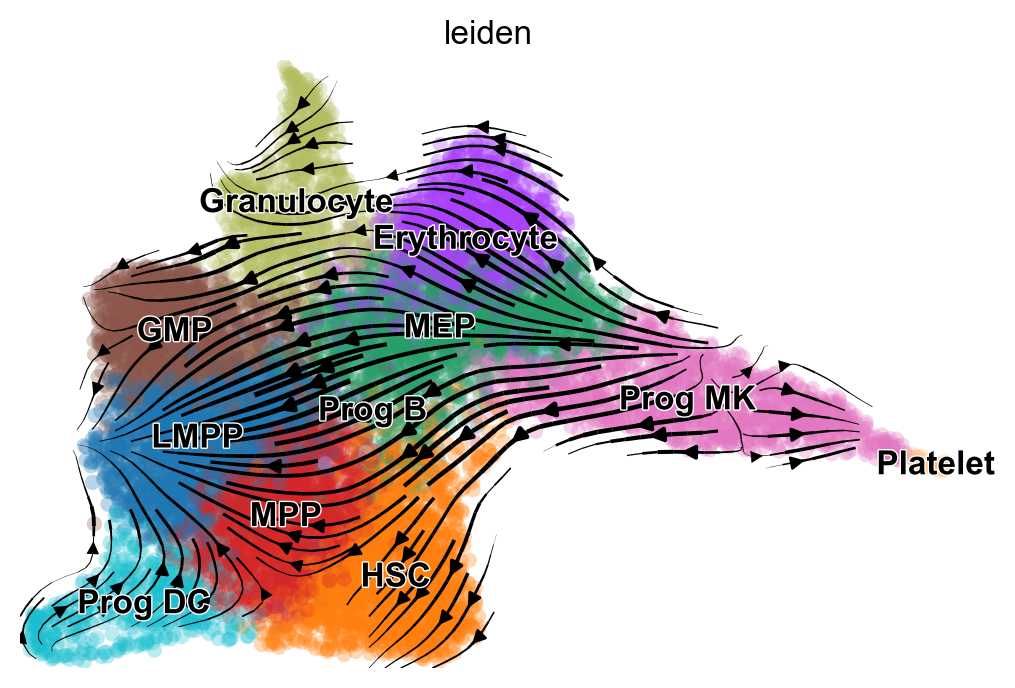

In [5]:
scv.tl.recover_dynamics(adata_rna)
scv.tl.velocity(adata_rna, mode="dynamical")
scv.tl.velocity_graph(adata_rna, n_jobs=1)
scv.tl.latent_time(adata_rna)
scv.pl.velocity_embedding_stream(adata_rna, basis='umap', color='leiden')

In [7]:
# This will take a while. Parallelization is high recommended.

adata_result = mv.recover_dynamics_chrom(adata_rna, 
                                        adata_atac,
                                        max_iter=5, 
                                        init_mode="invert", 
                                        verbose=False,
                                        parallel=True,
                                        n_jobs = 10,
                                        save_plot=False,
                                        rna_only=False,
                                        fit=True,
                                        n_anchors=500, 
                                        extra_color_key='leiden'
                                        )

  0%|          | 0/1000 [00:00<?, ?it/s]

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


In [8]:
# Save the result for use later on
adata_result.write("multivelo_result_fig5.h5ad")

In [22]:
h5ad_url = "https://figshare.com/ndownloader/files/40066924"
adata_result = sc.read("multivelo_result_fig5.h5ad", backup_url = h5ad_url)

## Computing velocity stream and latent time

In [23]:
mv.set_velocity_genes(adata_result, likelihood_lower=0.02)
mv.velocity_graph(adata_result)
mv.latent_time(adata_result)

computing velocity graph (using 1/10 cores)


  0%|          | 0/11605 [00:00<?, ?cells/s]

    finished (0:00:32) --> added 
    'velo_s_norm_graph', sparse matrix with cosine correlations (adata.uns)
computing latent time using root_cells as prior
    finished (0:00:02) --> added 
    'latent_time', shared time (adata.obs)


# Fig 5a

computing velocity embedding
    finished (0:00:02) --> added
    'velo_s_norm_umap', embedded velocity vectors (adata.obsm)


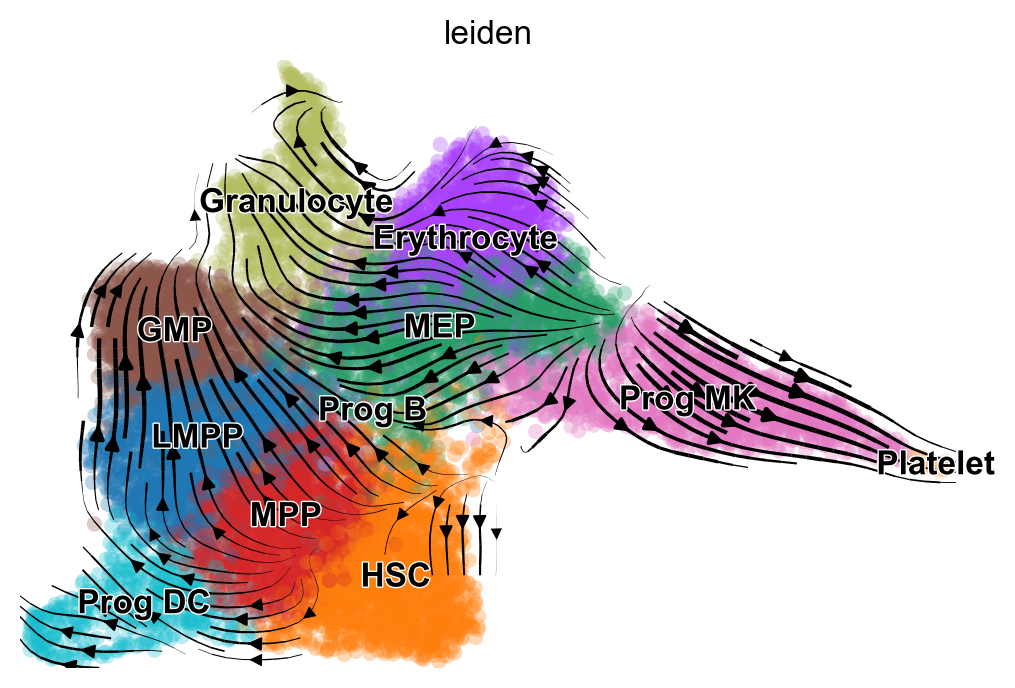

In [24]:
mv.velocity_embedding_stream(adata_result, basis='umap', color='leiden', show=True)

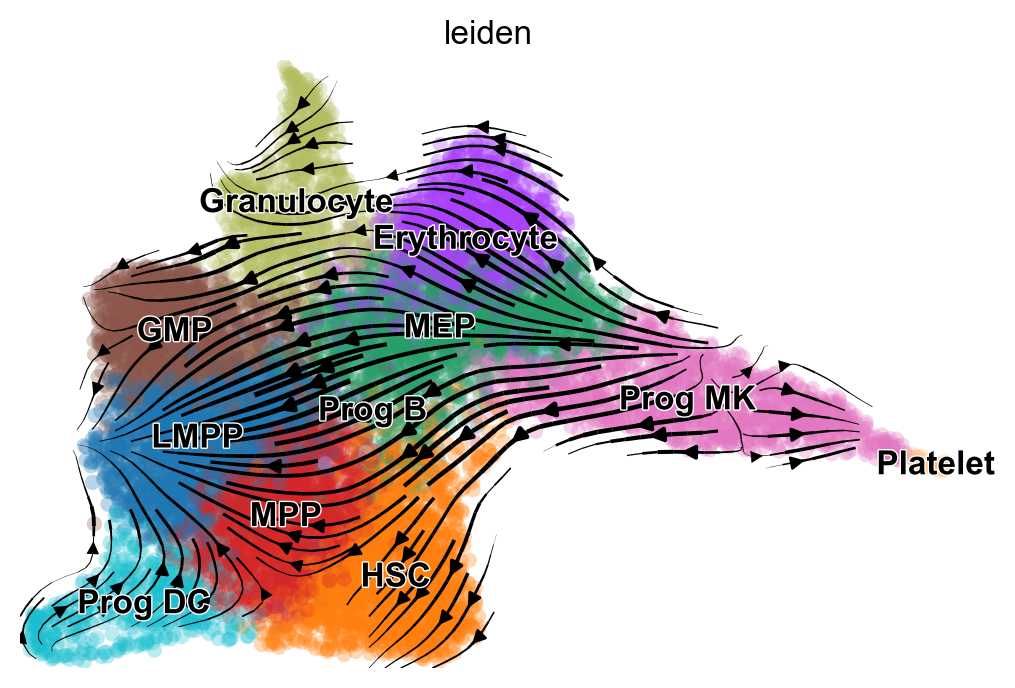

In [25]:
scv.pl.velocity_embedding_stream(adata_result, basis='umap', color='leiden')

# Fig 5b

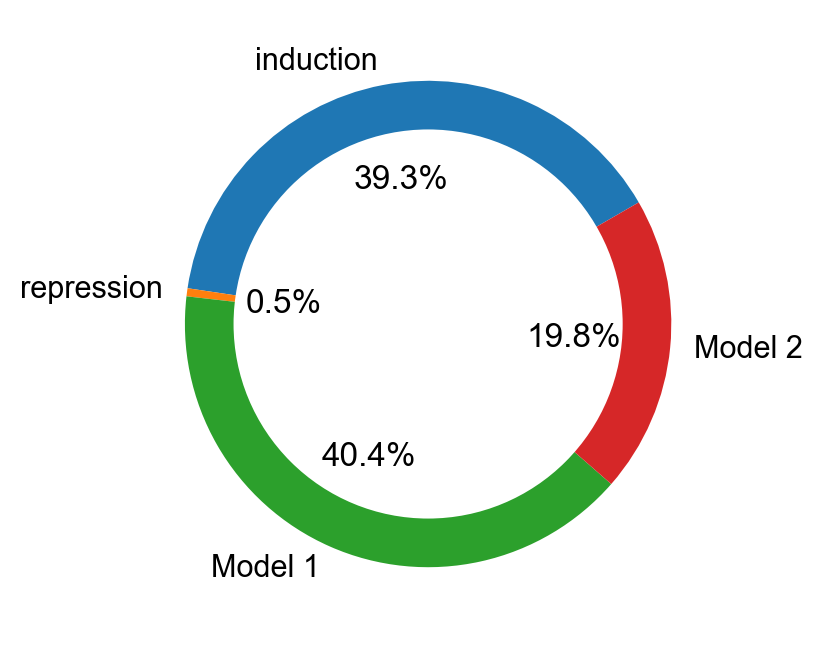

In [26]:
mv.pie_summary(adata_result)

# Fig 5c

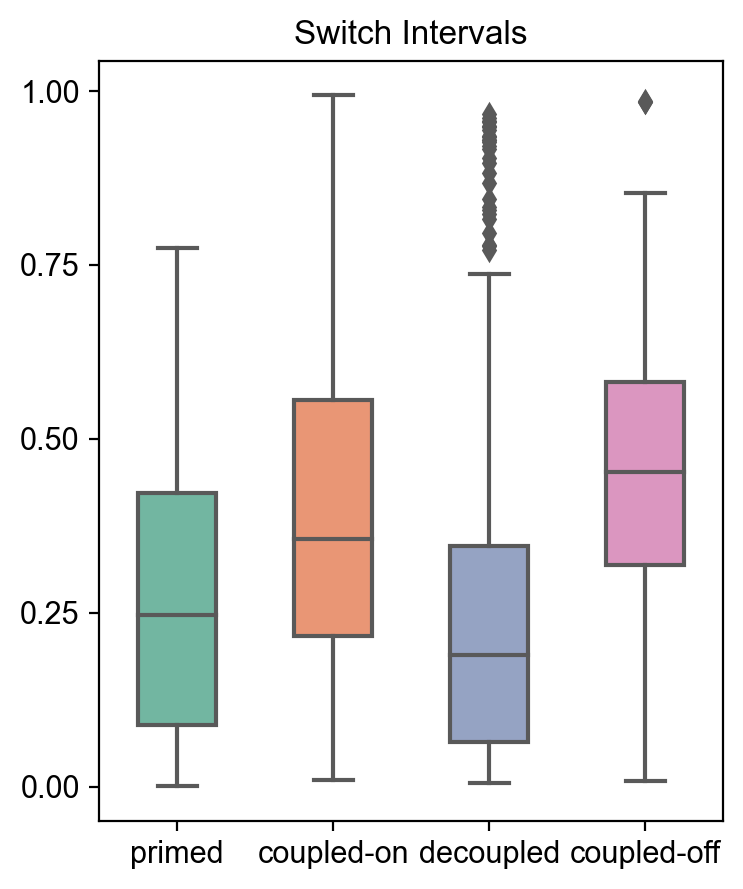

In [27]:
mv.switch_time_summary(adata_result)

# Fig 5d

In [28]:
# variables for subsetting the AnnData object to just the myeloid lineage
hsc_check = adata_result.obs['leiden'] == "HSC"
mpp_check = adata_result.obs['leiden'] == "MPP"
lmpp_check = adata_result.obs['leiden'] == "LMPP"
gmp_check = adata_result.obs['leiden'] == "GMP"

myeloid_check = (hsc_check | mpp_check | lmpp_check | gmp_check)


# variables for subsetting the AnnData object to just the erythrocyte lineage
erythrocyte_check = adata_result.obs['leiden'] == "Erythrocyte"
mep_check = adata_result.obs['leiden'] == "MEP"
hsc_check = adata_result.obs['leiden'] == "HSC"
progdc_check = adata_result.obs['leiden'] == "ProgDC"

erythroid_check = (erythrocyte_check | mep_check | hsc_check | progdc_check)


# variables for subsetting the AnnData object to just the platelet lineage
platelet_check = adata_result.obs['leiden'] == "Platelet"
progmk_check = adata_result.obs['leiden'] == "Prog MK"
mep_check = adata_result.obs['leiden'] == "MEP"

platelet_lineage_check = (platelet_check | progmk_check | mep_check | hsc_check)

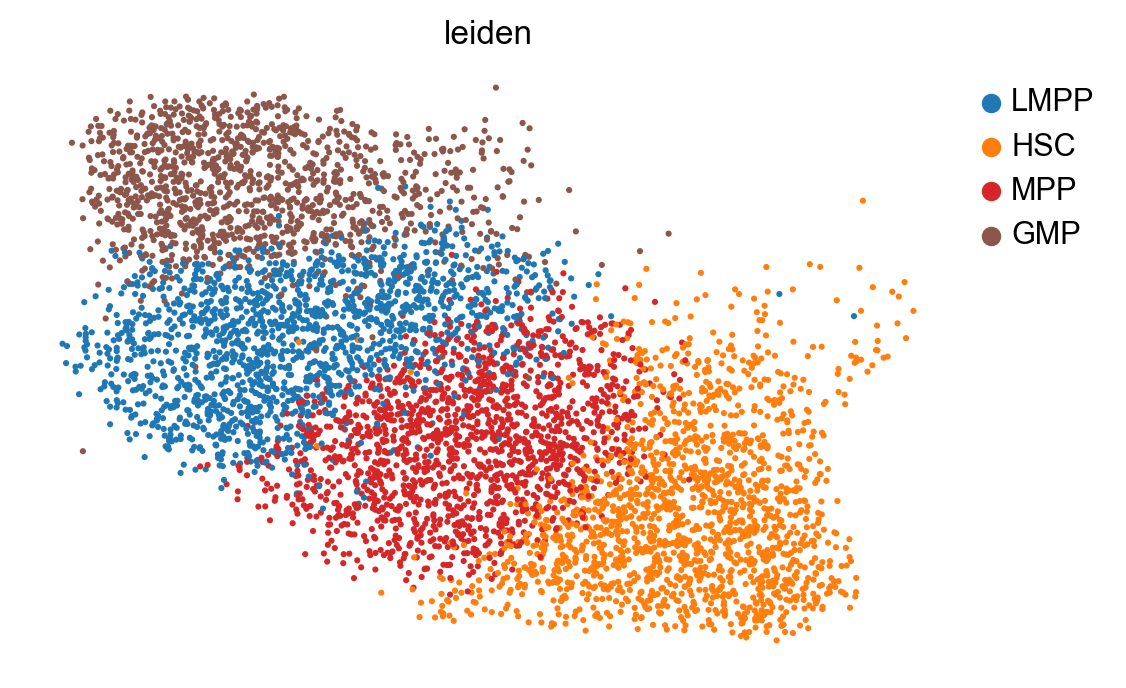

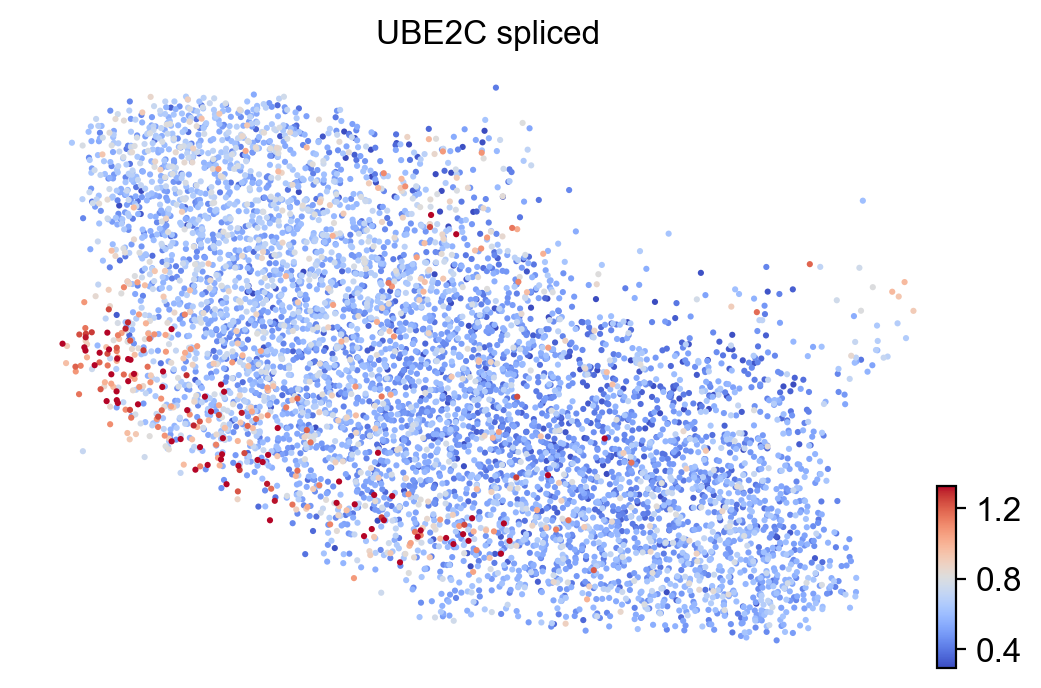

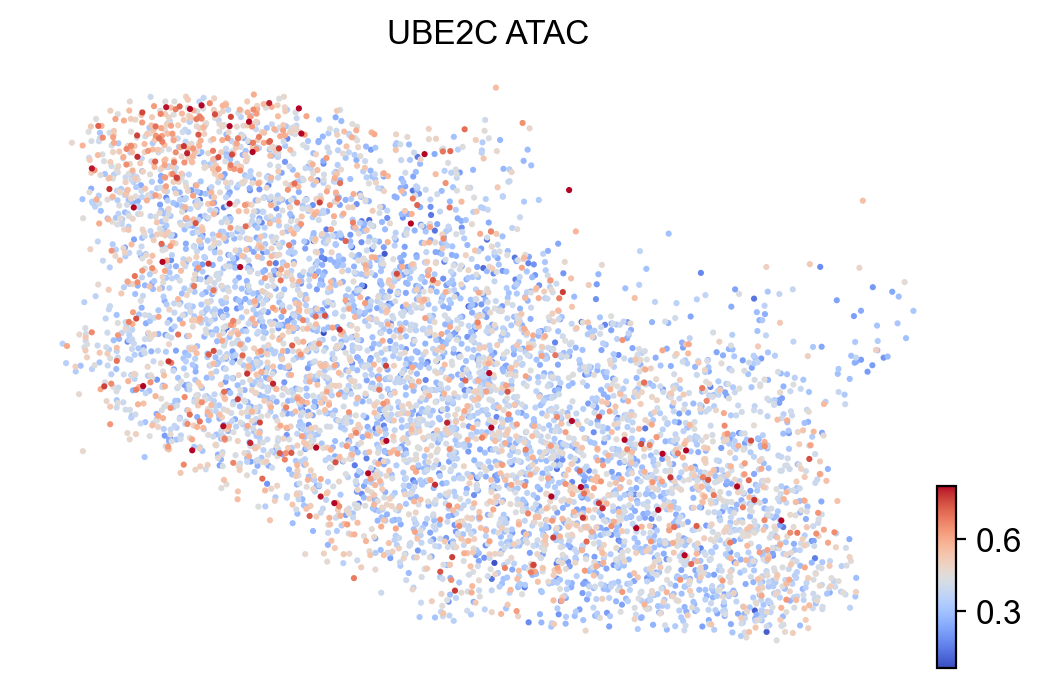

In [29]:
myeloid_data = adata_result[myeloid_check, :]

scv.pl.umap(myeloid_data, color='leiden')
scv.pl.umap(myeloid_data, color='UBE2C', layer='Ms', title='UBE2C spliced', cmap="coolwarm")
scv.pl.umap(myeloid_data, color='UBE2C', layer='ATAC', title='UBE2C ATAC', perc=[0,99.5], cmap="coolwarm")

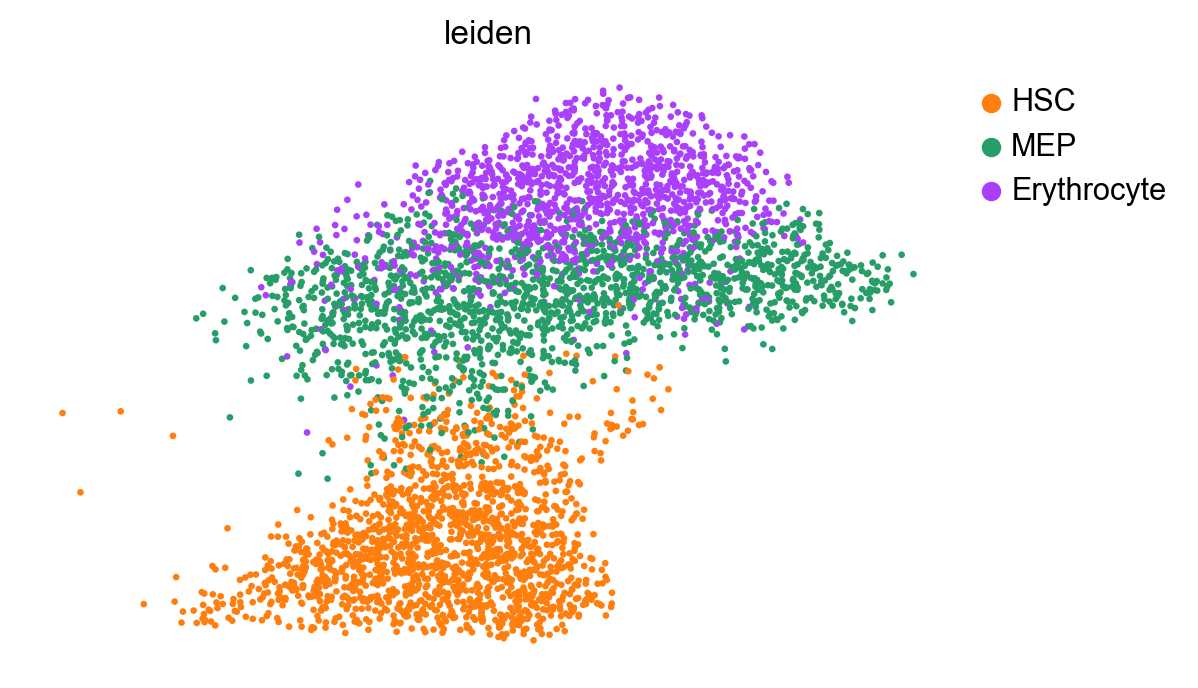

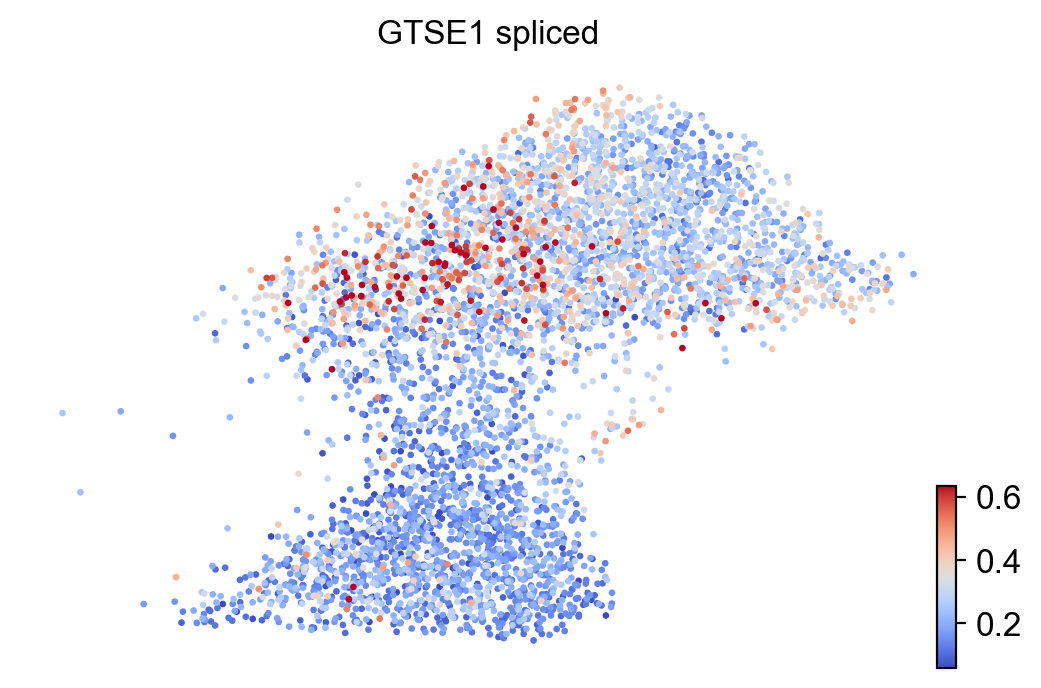

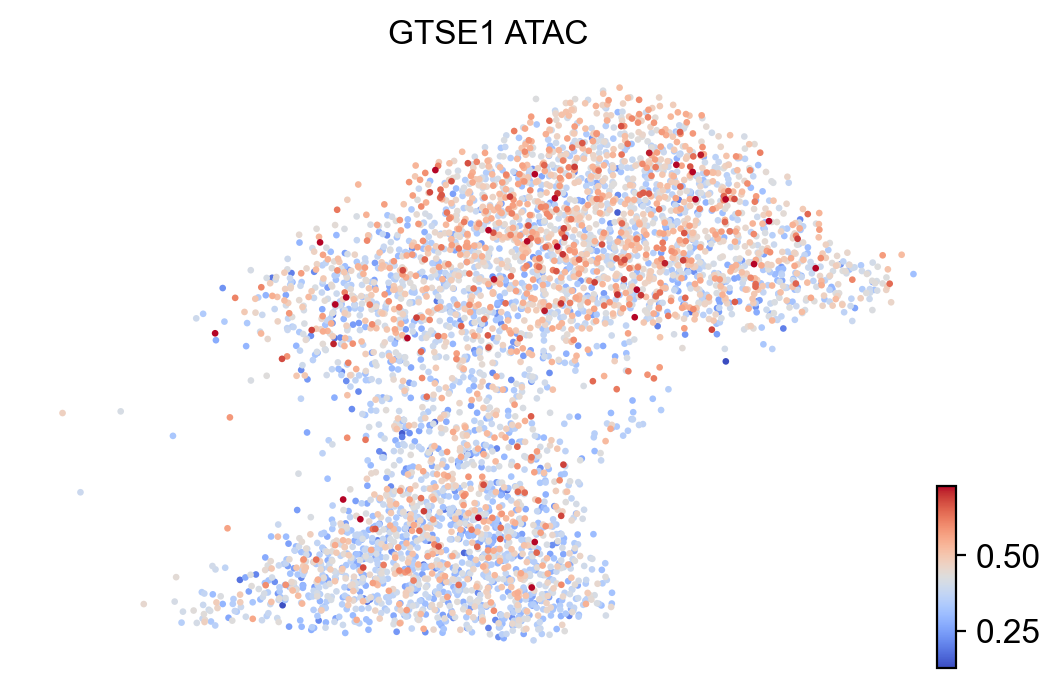

In [30]:
erythroid_data = adata_result[erythroid_check, :]

scv.pl.umap(erythroid_data, color='leiden')
scv.pl.umap(erythroid_data, color='GTSE1', layer='Ms', title='GTSE1 spliced', cmap="coolwarm")
scv.pl.umap(erythroid_data, color='GTSE1', layer='ATAC', title='GTSE1 ATAC', perc=[0,99.5], cmap="coolwarm")

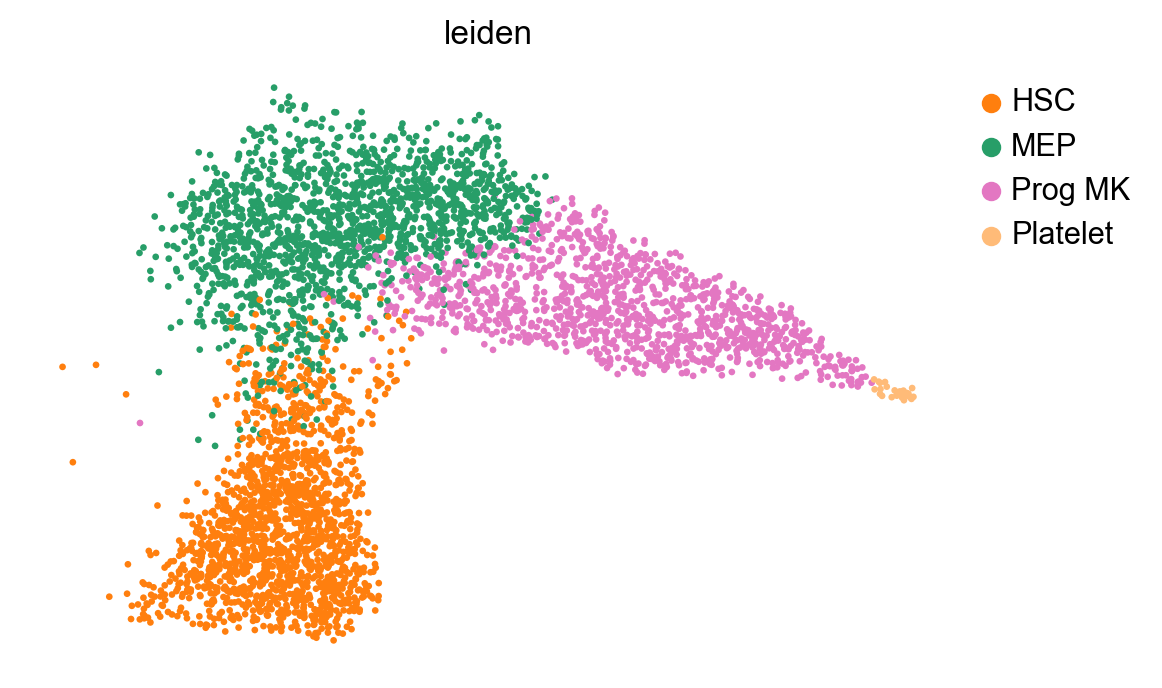

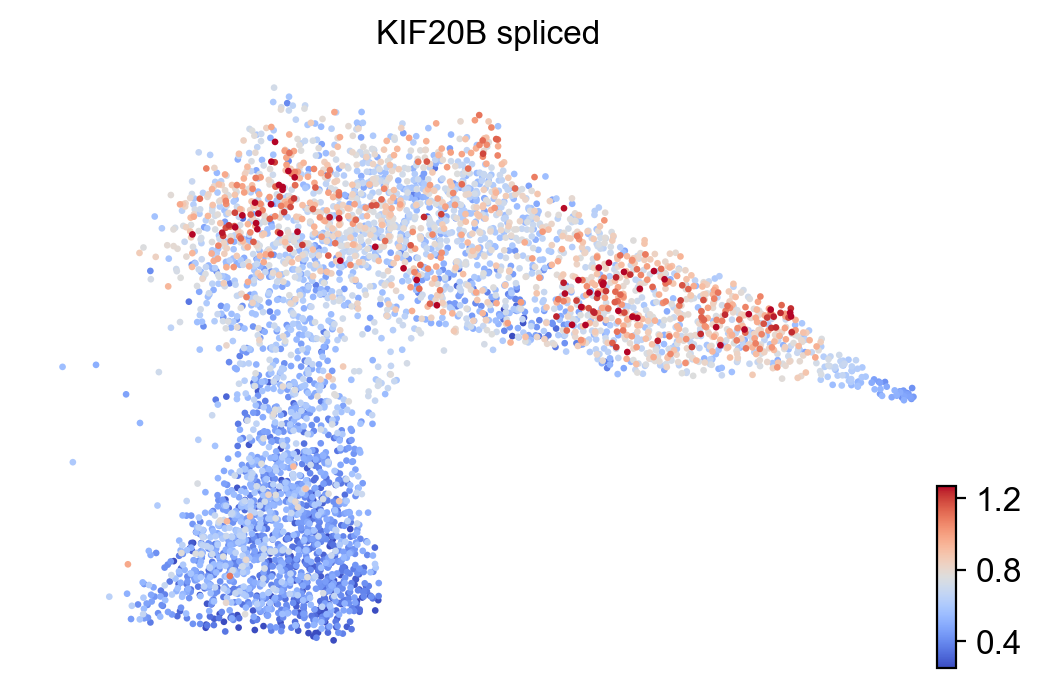

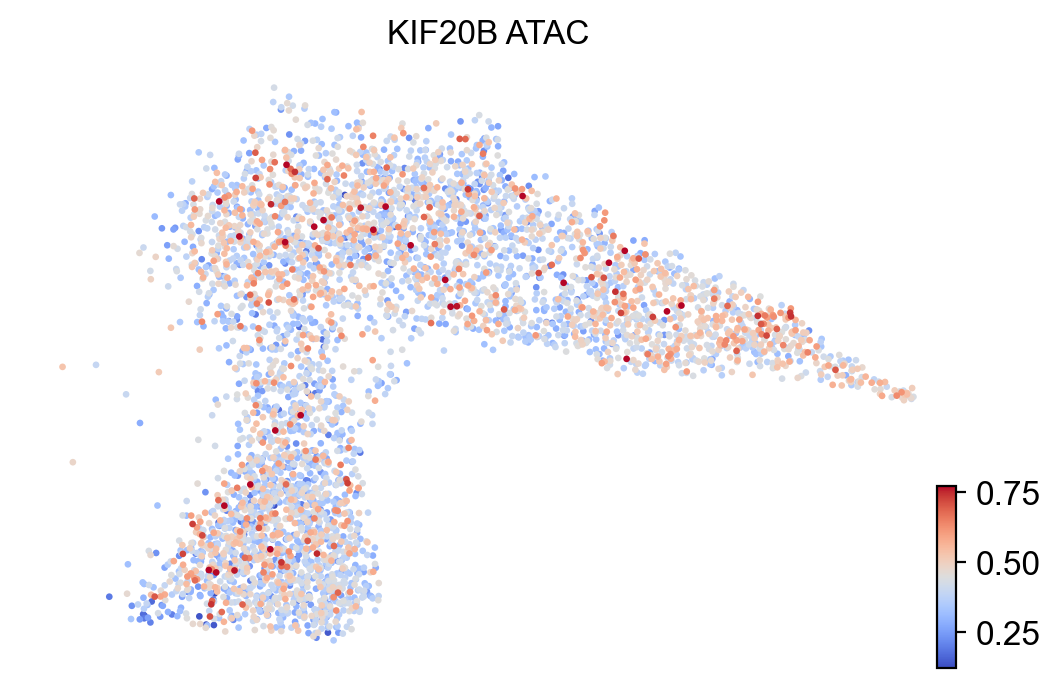

In [31]:
platelet_data = adata_result[platelet_lineage_check, :]

scv.pl.umap(platelet_data, color='leiden')
scv.pl.umap(platelet_data, color='KIF20B', layer='Ms', title='KIF20B spliced', cmap="coolwarm")
scv.pl.umap(platelet_data, color='KIF20B', layer='ATAC', title='KIF20B ATAC', perc=[0,99.5], cmap="coolwarm")

# Fig 5e

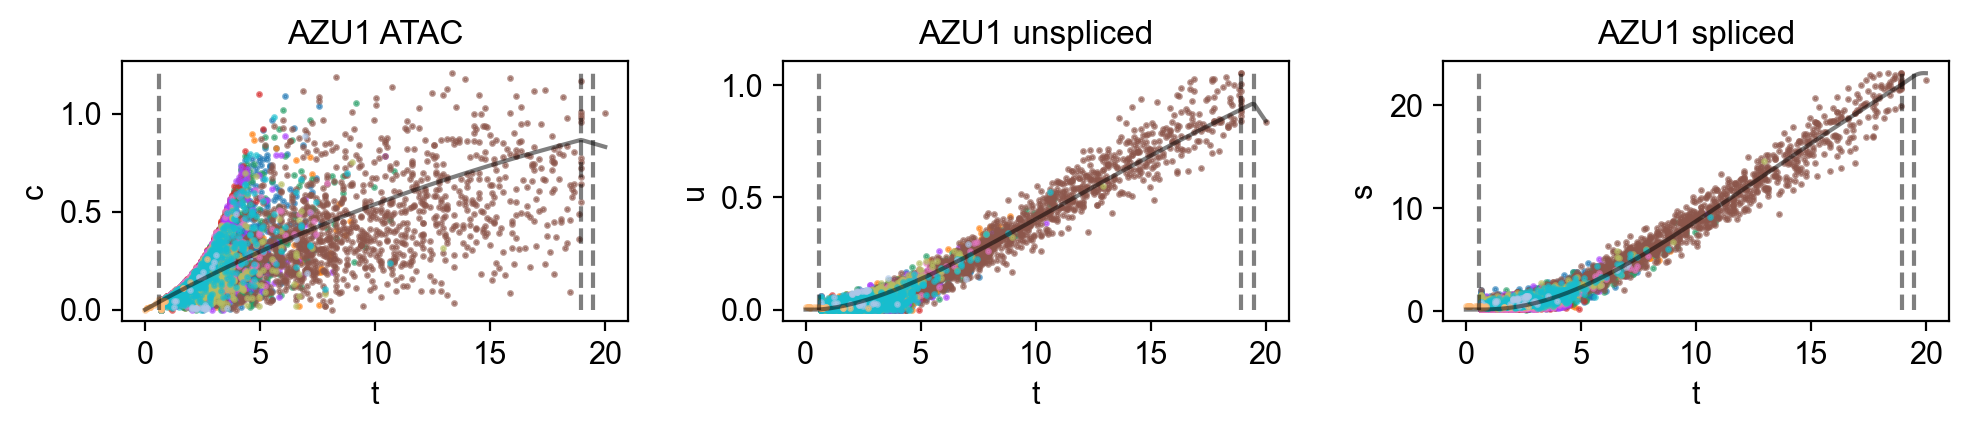

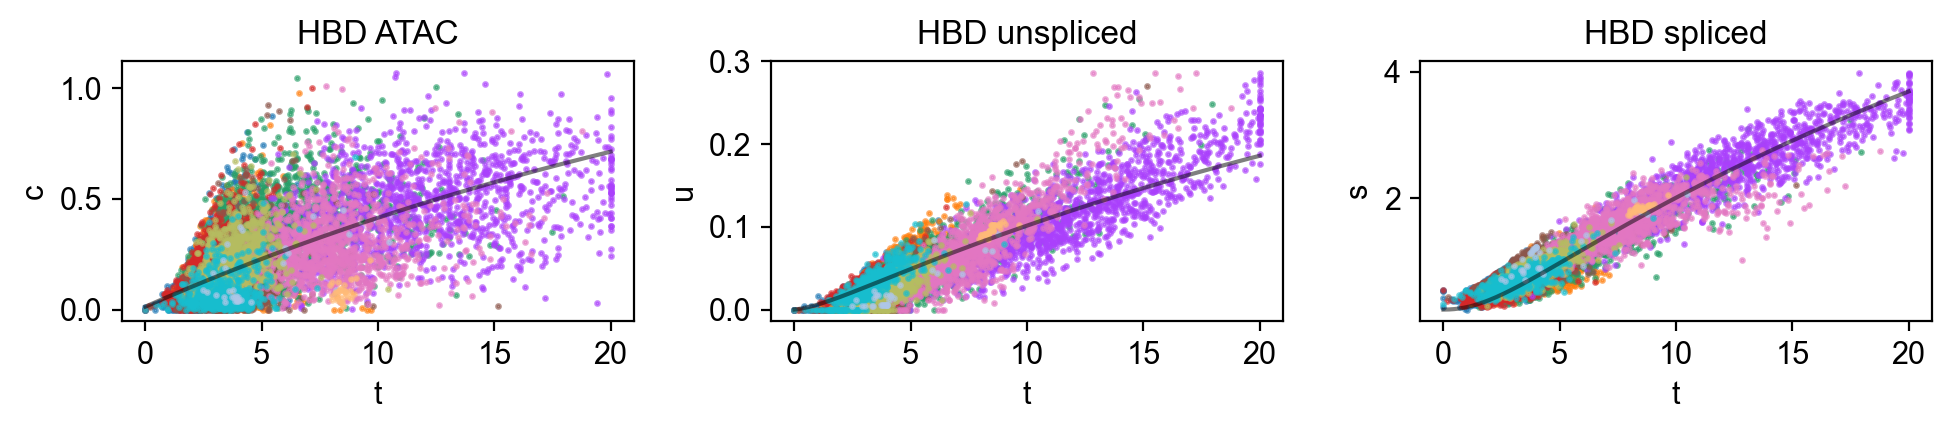

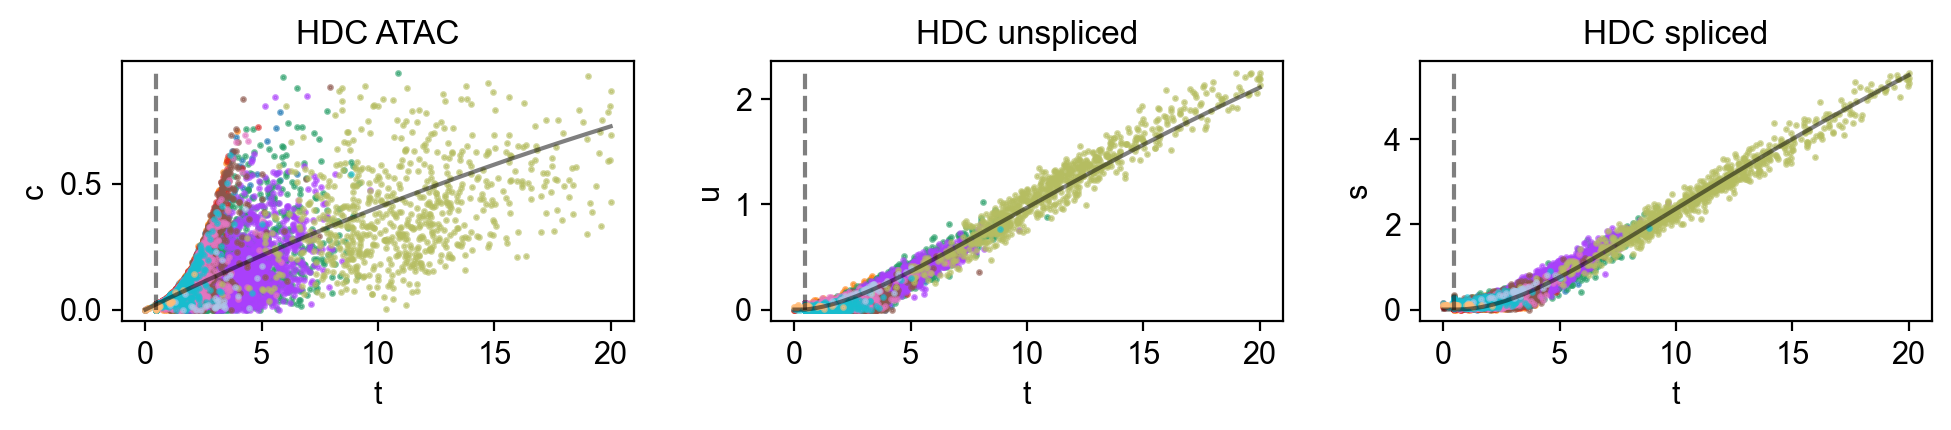

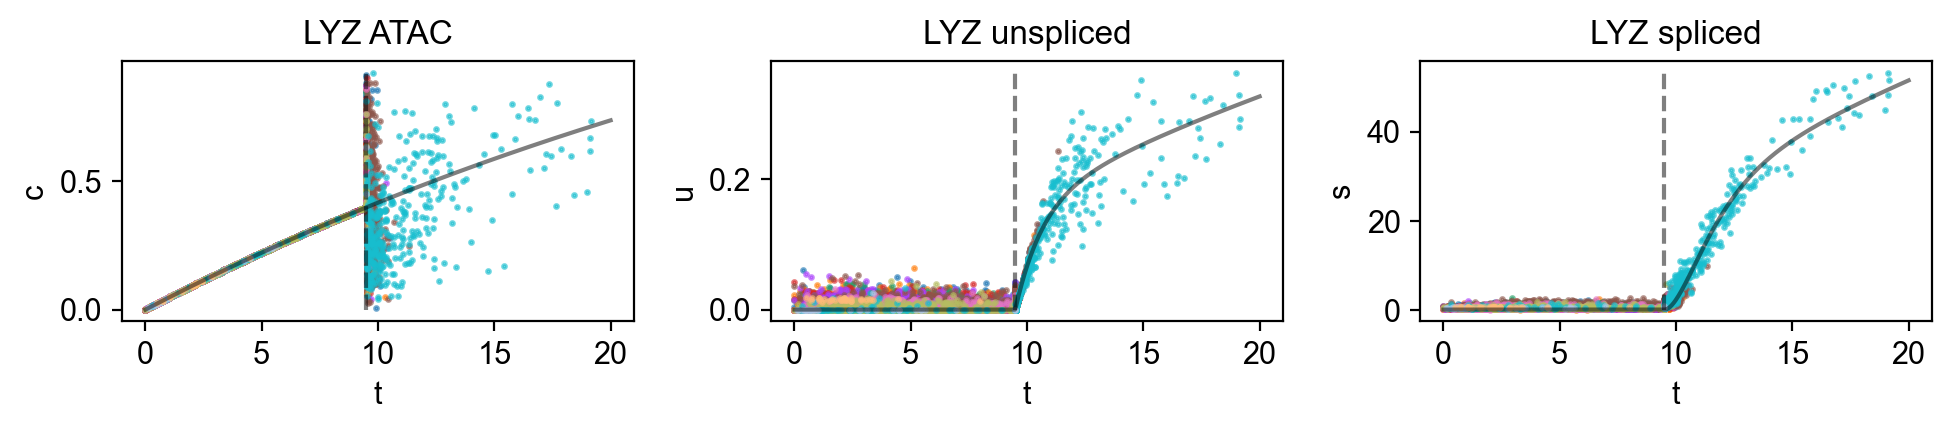

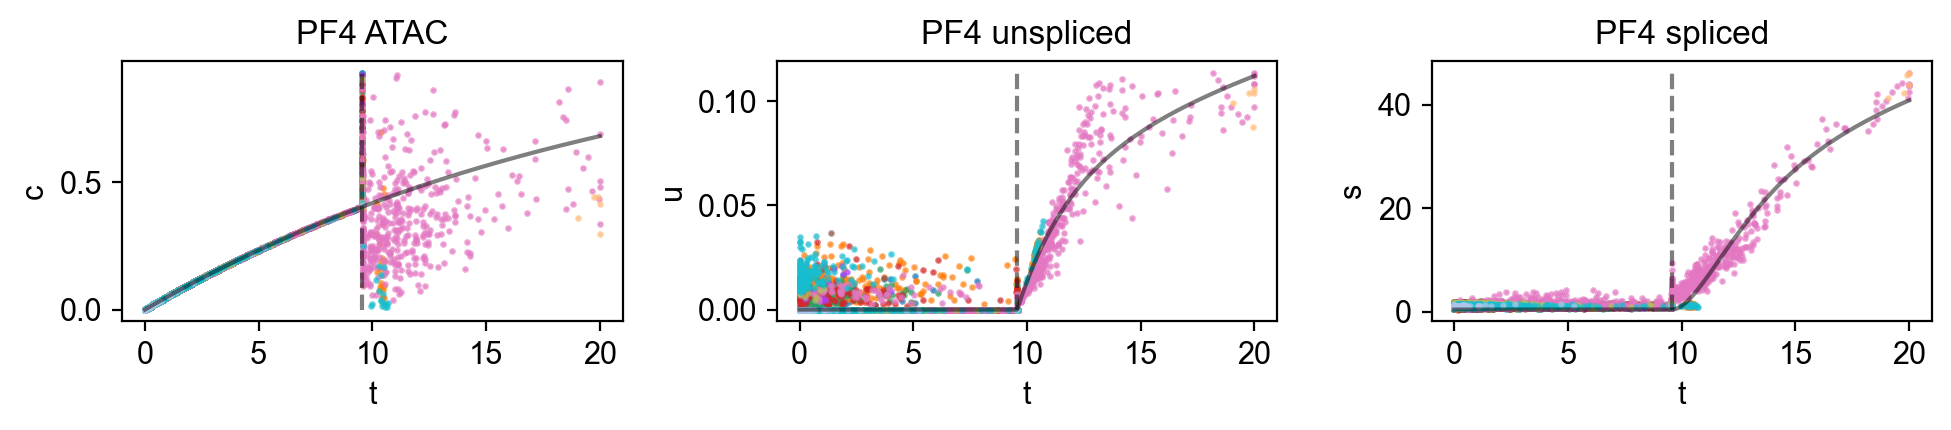

In [32]:
genes = ["AZU1", "HBD", "HDC", "LYZ", "PF4"]

for gene in genes:
    mv.dynamic_plot(adata_result, genes=gene, color_by="leiden", cmap="tab20")

# Fig 5f

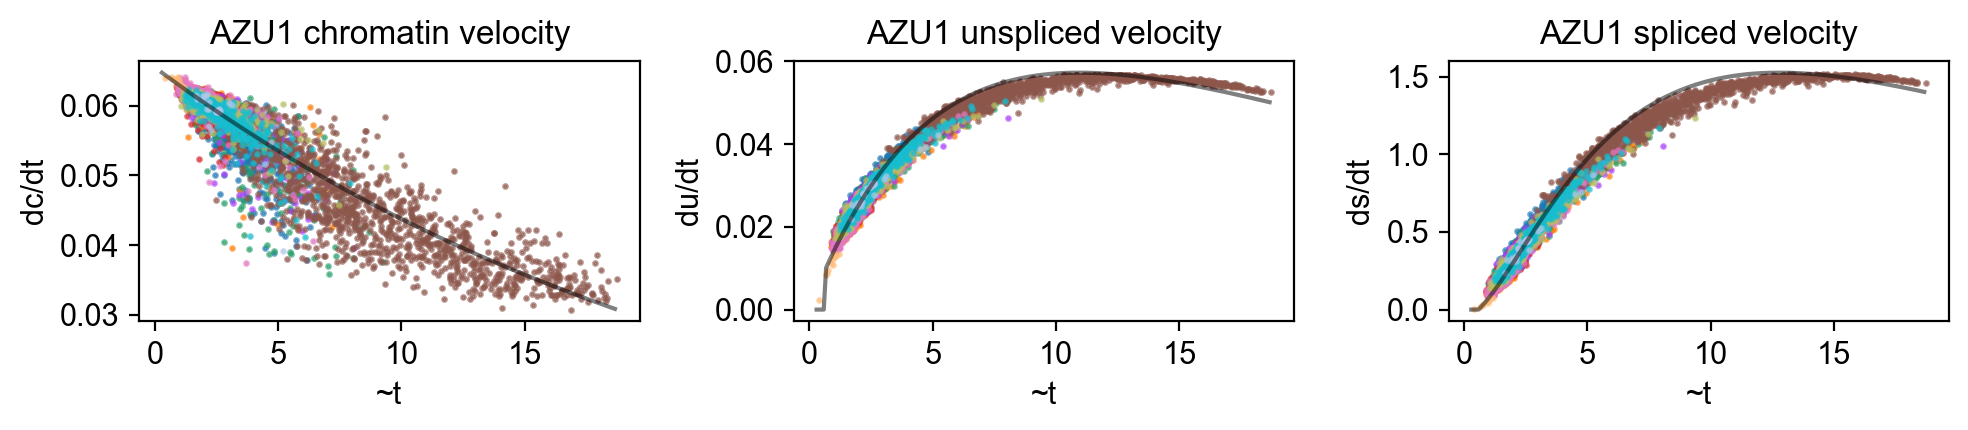

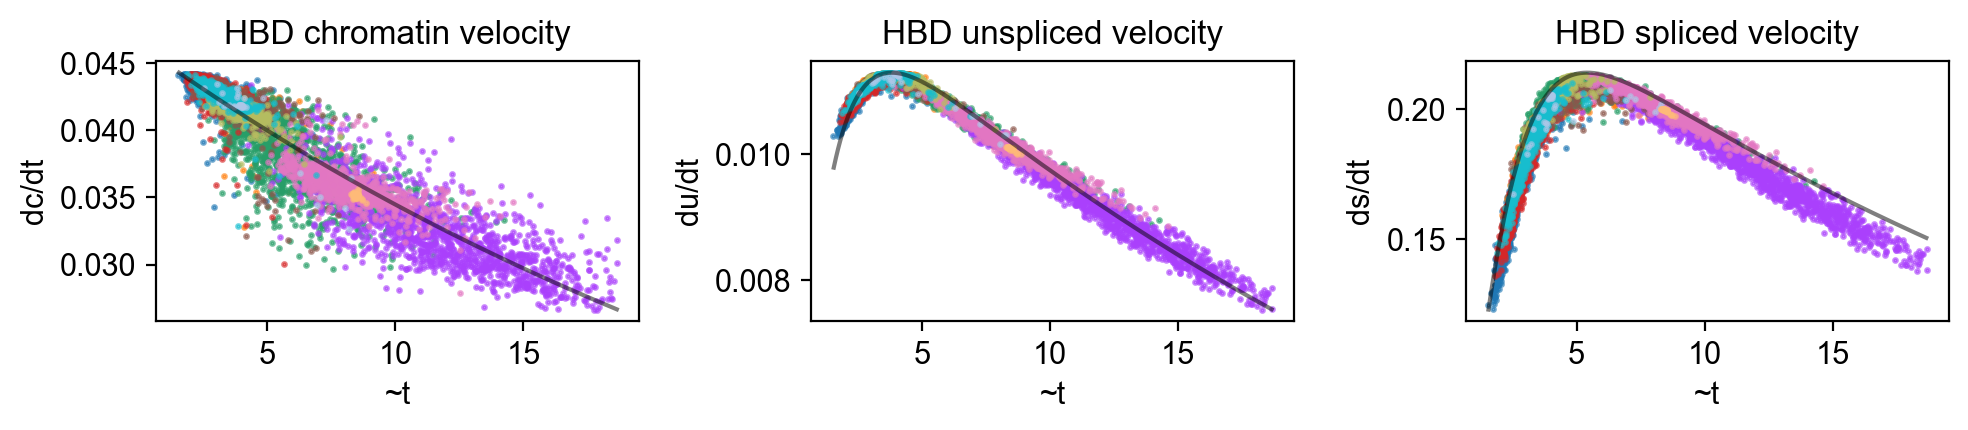

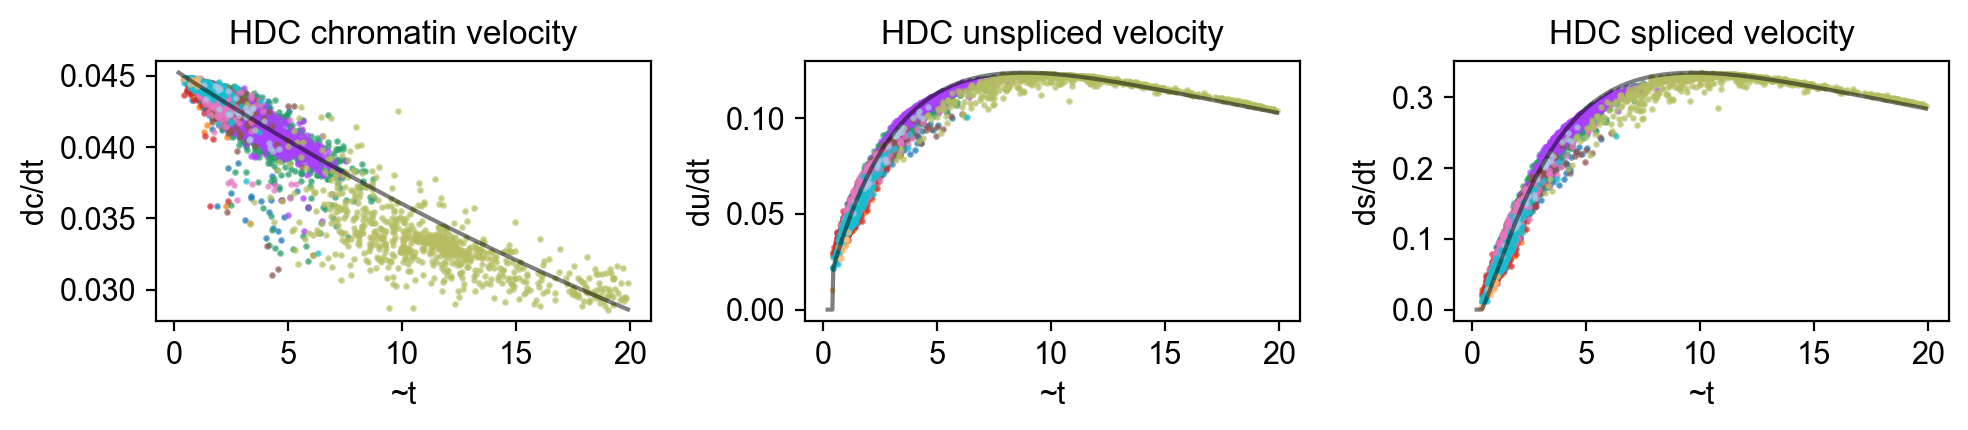

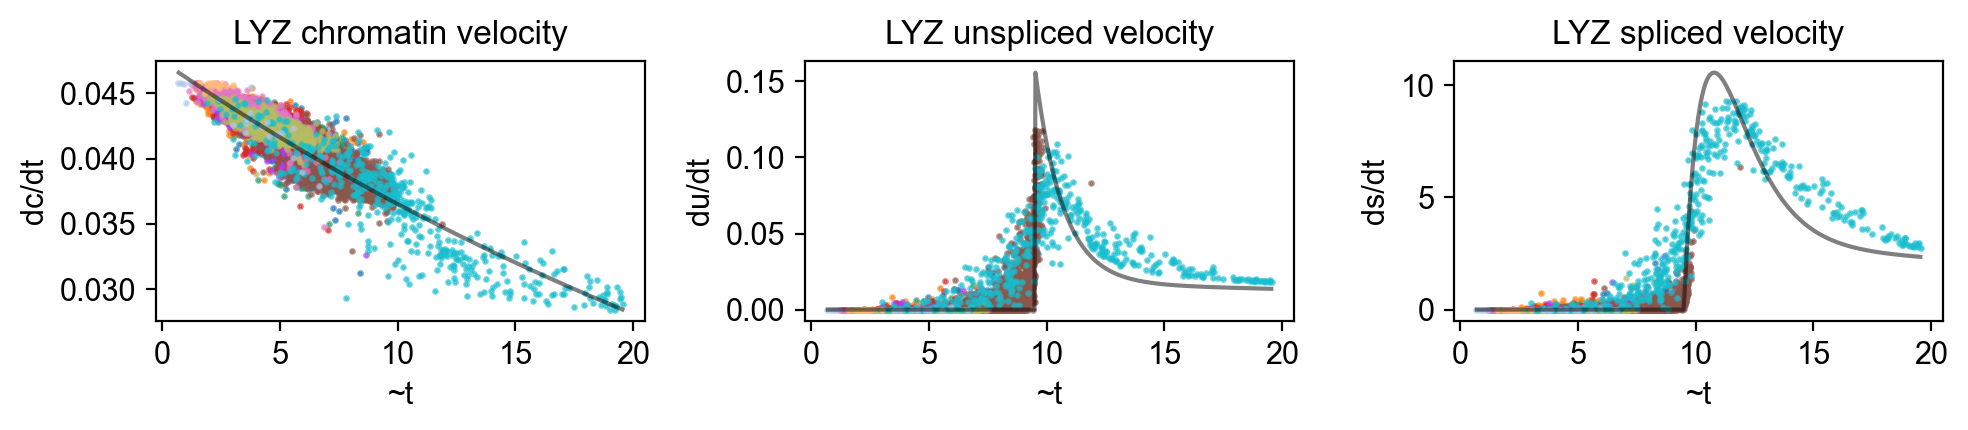

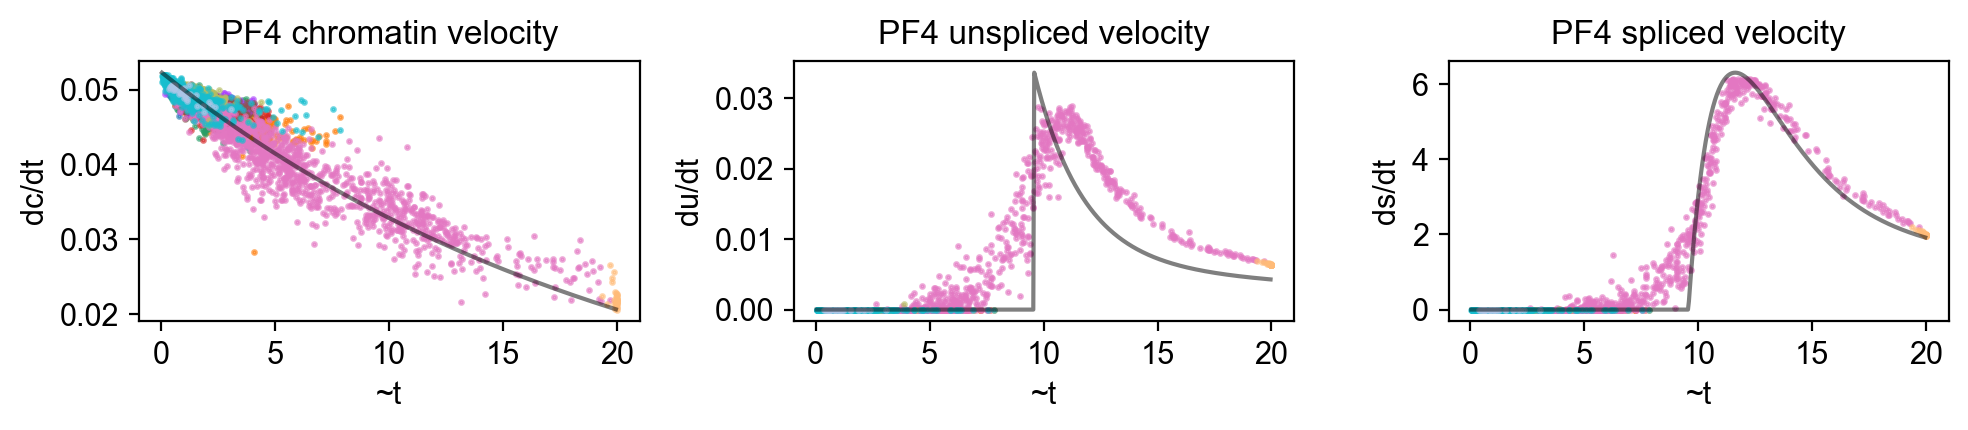

In [33]:
genes = ["AZU1", "HBD", "HDC", "LYZ", "PF4"]

for gene in genes:
    mv.dynamic_plot(adata_result, by="velocity", genes=gene, color_by="leiden", cmap="tab20")

# Fig 5g

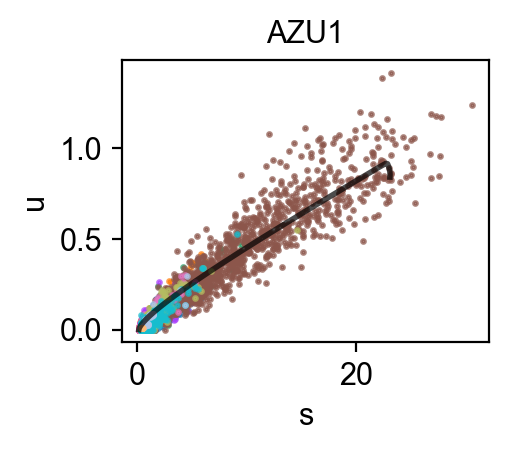

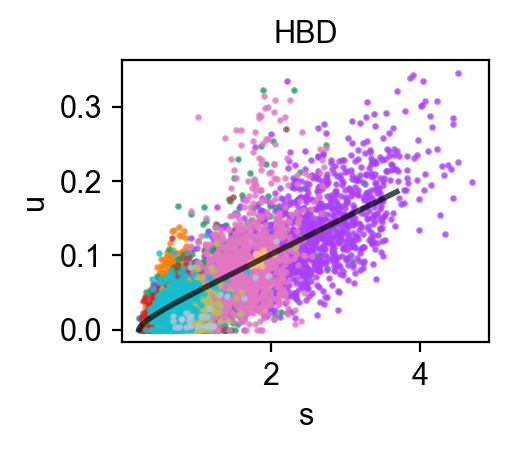

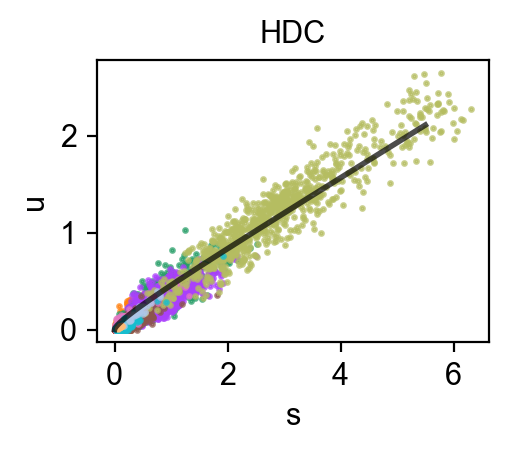

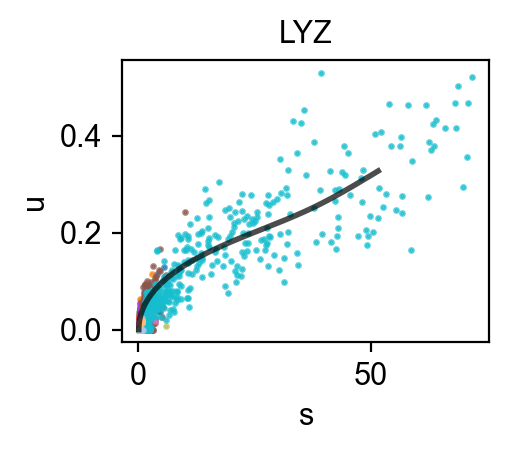

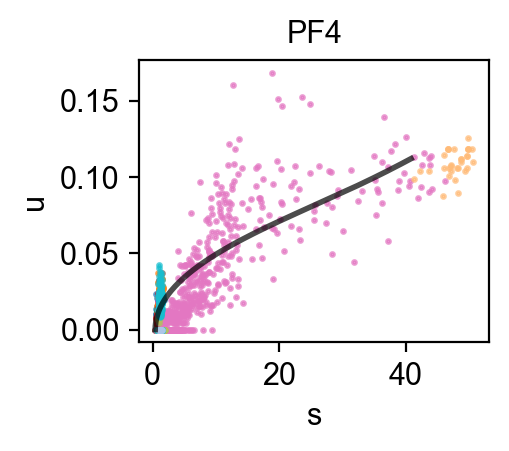

In [34]:
genes = ["AZU1", "HBD", "HDC", "LYZ", "PF4"]

for gene in genes:
    mv.scatter_plot(adata_result, genes=gene, color_by="leiden", cmap="tab20", show_switches=False)